# <b><u>Retail Store Demand Forecasting - Comprehensive Machine Learning Pipeline<u><b>  

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load the dataset
df = pd.read_csv('../datasets/retail_store_inventory.csv')
df.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [3]:
df.shape

(73100, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [5]:
df.isna().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [31]:
print("\n=== NaN Values Before Handling ===")
print(df.isna().sum())


=== NaN Values Before Handling ===
Date                    0
Store ID                0
Product ID              0
Category                0
Region                  0
Inventory Level         0
Units Sold              0
Units Ordered           0
Demand Forecast         0
Price                   0
Discount                0
Weather Condition       0
Holiday/Promotion       0
Competitor Pricing      0
Seasonality             0
Year                    0
Month                   0
Day                     0
DayOfWeek               0
DayOfYear               0
WeekOfYear              0
Price_Diff              0
Price_Elasticity        0
Inventory_Turnover      0
Prev_Day_Sales        100
Rolling_7_Day_Avg       0
dtype: int64



### <b>Exploratory Data Analysis (EDA)</b>



In [7]:
print("\n=== Basic Dataset Info ===")
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isna().sum())



=== Basic Dataset Info ===
Dataset shape: (73100, 15)

Data types:
Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object

Missing values:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


In [8]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Summary statistics
print("\n=== Numerical Features Summary ===")
print(df.describe())



=== Numerical Features Summary ===
       Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000  73100.000000       73100.000000        73100.000000  
mean      55.135108     10.009508           0.497305           55.146077  
std       26.021945      7.083746           0.499996           26.191408  
min       10.00

In [9]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# Summary statistics
print("\n=== Numerical Features Summary ===")
print(df.describe())


=== Numerical Features Summary ===
       Inventory Level    Units Sold  Units Ordered  Demand Forecast  \
count     73100.000000  73100.000000   73100.000000     73100.000000   
mean        274.469877    136.464870     110.004473       141.494720   
std         129.949514    108.919406      52.277448       109.254076   
min          50.000000      0.000000      20.000000        -9.990000   
25%         162.000000     49.000000      65.000000        53.670000   
50%         273.000000    107.000000     110.000000       113.015000   
75%         387.000000    203.000000     155.000000       208.052500   
max         500.000000    499.000000     200.000000       518.550000   

              Price      Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000  73100.000000       73100.000000        73100.000000  
mean      55.135108     10.009508           0.497305           55.146077  
std       26.021945      7.083746           0.499996           26.191408  
min       10.00

In [11]:
print("\n=== Categorical Features Summary ===")
print(df.describe(include=['object']))


=== Categorical Features Summary ===
       Store ID Product ID   Category Region Weather Condition Seasonality
count     73100      73100      73100  73100             73100       73100
unique        5         20          5      4                 4           4
top        S001      P0001  Furniture   East             Sunny      Spring
freq      14620       3655      14699  18349             18290       18317


In [12]:
# Time period analysis
print("\nDate range:")
print(f"Start: {df['Date'].min()}")
print(f"End: {df['Date'].max()}")


Date range:
Start: 2022-01-01 00:00:00
End: 2024-01-01 00:00:00


### <b>Visualizations

Text(0.5, 1.0, 'Distribution of Units Sold')

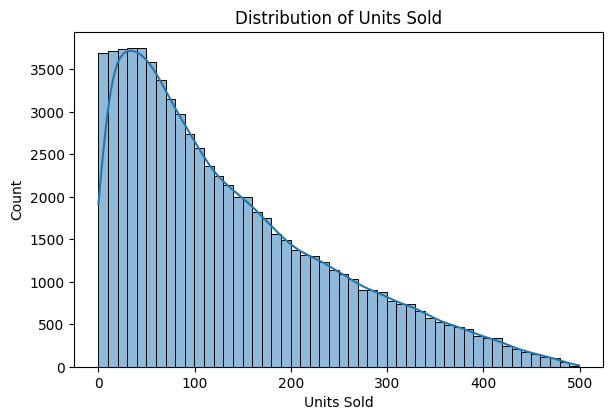

In [13]:
plt.figure(figsize=(15, 20))

# 1. Target variable distribution (Units Sold)
plt.subplot(4, 2, 1)
sns.histplot(df['Units Sold'], bins=50, kde=True)
plt.title('Distribution of Units Sold')

Text(0, 0.5, 'Units Sold')

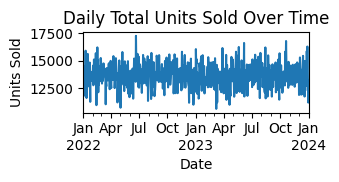

In [14]:
# 2. Sales over time
plt.subplot(4, 2, 2)
daily_sales = df.groupby('Date')['Units Sold'].sum()
daily_sales.plot()
plt.title('Daily Total Units Sold Over Time')
plt.ylabel('Units Sold')



([0, 1, 2, 3, 4],
 [Text(0, 0, 'Groceries'),
  Text(1, 0, 'Toys'),
  Text(2, 0, 'Electronics'),
  Text(3, 0, 'Furniture'),
  Text(4, 0, 'Clothing')])

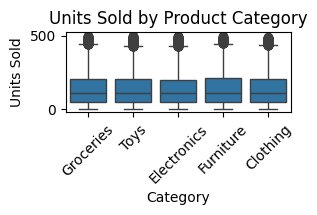

In [15]:
# 3. Sales by category
plt.subplot(4, 2, 3)
sns.boxplot(data=df, x='Category', y='Units Sold')
plt.title('Units Sold by Product Category')
plt.xticks(rotation=45)


Text(0.5, 1.0, 'Units Sold by Region')

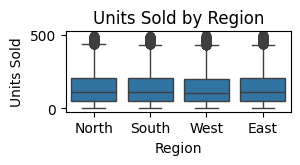

In [16]:
# 4. Sales by region
plt.subplot(4, 2, 4)
sns.boxplot(data=df, x='Region', y='Units Sold')
plt.title('Units Sold by Region')


Text(0.5, 1.0, 'Price vs Units Sold')

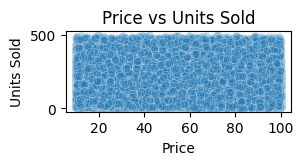

In [17]:
# 5. Price vs Units Sold
plt.subplot(4, 2, 5)
sns.scatterplot(data=df, x='Price', y='Units Sold', alpha=0.3)
plt.title('Price vs Units Sold')



Text(0.5, 1.0, 'Discount Impact on Units Sold')

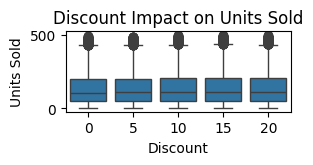

In [18]:
# 6. Discount impact
plt.subplot(4, 2, 6)
sns.boxplot(data=df, x='Discount', y='Units Sold')
plt.title('Discount Impact on Units Sold')

Text(0.5, 1.0, 'Holiday/Promotion Impact on Units Sold')

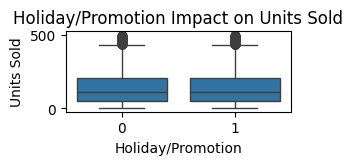

In [19]:
# 7. Holiday/Promotion impact
plt.subplot(4, 2, 7)
sns.boxplot(data=df, x='Holiday/Promotion', y='Units Sold')
plt.title('Holiday/Promotion Impact on Units Sold')

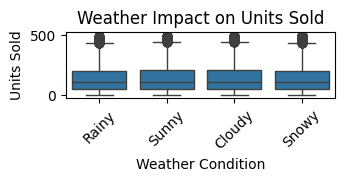

In [20]:
# 8. Weather impact
plt.subplot(4, 2, 8)
sns.boxplot(data=df, x='Weather Condition', y='Units Sold')
plt.title('Weather Impact on Units Sold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


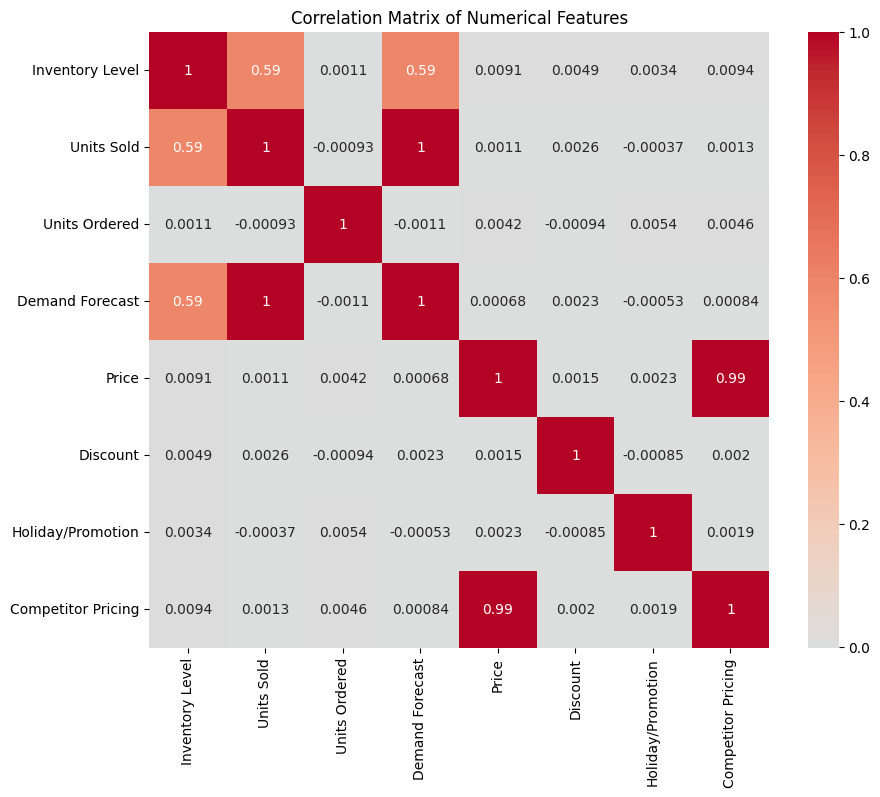

In [21]:
# Correlation matrix
numerical_cols = ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 
                 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### <b>Feature Engineering

In [32]:
# Extract temporal features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week



In [33]:
# Price difference with competitor
df['Price_Diff'] = df['Price'] - df['Competitor Pricing']

# Price elasticity feature (add small constant to avoid divide by zero)
df['Price_Elasticity'] = df['Units Sold'] / (df['Price'] + 1e-6)

# Inventory turnover rate (handle zero inventory)
df['Inventory_Turnover'] = df['Units Sold'] / df['Inventory Level'].replace(0, 1)

# Lag features (previous day's sales) - fill NaN with 0 or appropriate value
df.sort_values(['Store ID', 'Product ID', 'Date'], inplace=True)
df['Prev_Day_Sales'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(1)
df['Prev_Day_Sales'].fillna(0, inplace=True)  # Fill first day's NaN with 0

# Rolling window features - use min_periods=1 to avoid NaN
df['Rolling_7_Day_Avg'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Verify no NaN values remain
print("\n=== NaN Values After Handling ===")
print(df.isna().sum())


=== NaN Values After Handling ===
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
Year                  0
Month                 0
Day                   0
DayOfWeek             0
DayOfYear             0
WeekOfYear            0
Price_Diff            0
Price_Elasticity      0
Inventory_Turnover    0
Prev_Day_Sales        0
Rolling_7_Day_Avg     0
dtype: int64


In [34]:
numerical_cols = [col for col in X.columns 
                 if col not in categorical_cols 
                 and col not in ['Year', 'Month', 'Day']
                 and df[col].dtype in ['int64', 'float64']]

In [35]:
# Create transformers with SimpleImputer for numerical features
from sklearn.impute import SimpleImputer

numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),  # Handle any remaining NaN
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # Handle any NaN in categorical
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [36]:
X = df.drop(['Units Sold', 'Date', 'Demand Forecast'], axis=1)
y = df['Units Sold']

In [37]:
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [41]:
# Preprocessing pipeline
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
numerical_cols = [col for col in X.columns if col not in categorical_cols and col not in ['Year', 'Month', 'Day']]

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### <b>Model Training and Evaluation

In [43]:

# Define evaluation metrics
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train predictions
    y_train_pred = model.predict(X_train)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results = {
        'Model': model_name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R2': train_r2,
        'Test R2': test_r2
    }
    # Plot feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        try:
            # Get feature names after one-hot encoding
            feature_names = numerical_cols + list(model.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
            
            plt.figure(figsize=(10, 6))
            importances = model.named_steps['regressor'].feature_importances_
            indices = np.argsort(importances)[-20:]  # Top 20 features
            plt.title(f'Feature Importances - {model_name}')
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.tight_layout()
            plt.show()
        except:
            pass
    
    return results

In [39]:
# Initialize results dataframe
results_df = pd.DataFrame(columns=['Model', 'Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE', 'Train R2', 'Test R2'])

In [40]:
# Model 1: Linear Regression
print("\nLinear Regression with NaN handling...")
lr_pipe = make_pipeline(preprocessor, LinearRegression())
lr_pipe.fit(X_train, y_train)
lr_results = evaluate_model(lr_pipe, X_train, y_train, X_test, y_test, 'Linear Regression')
results_df = pd.DataFrame([lr_results])


Linear Regression with NaN handling...


In [44]:
# Model 2: Random Forest
print("\nTraining Random Forest...")
rf_pipe = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rf_pipe.fit(X_train, y_train)
rf_results = evaluate_model(rf_pipe, X_train, y_train, X_test, y_test, 'Random Forest')
results_df = results_df.append(rf_results, ignore_index=True)


Training Random Forest...


In [45]:
# Model 3: XGBoost
print("\nTraining XGBoost...")
xgb_pipe = make_pipeline(preprocessor, 
                        XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
xgb_pipe.fit(X_train, y_train)
xgb_results = evaluate_model(xgb_pipe, X_train, y_train, X_test, y_test, 'XGBoost')
results_df = results_df.append(xgb_results, ignore_index=True)


Training XGBoost...


In [46]:
# Model 4: LightGBM
print("\nTraining LightGBM...")
lgbm_pipe = make_pipeline(preprocessor, 
                         LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
lgbm_pipe.fit(X_train, y_train)
lgbm_results = evaluate_model(lgbm_pipe, X_train, y_train, X_test, y_test, 'LightGBM')
results_df = results_df.append(lgbm_results, ignore_index=True)



Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 58480, number of used features: 55
[LightGBM] [Info] Start training from score 136.207353


In [47]:
# Model 5: Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_pipe = make_pipeline(preprocessor, 
                       GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
gb_pipe.fit(X_train, y_train)
gb_results = evaluate_model(gb_pipe, X_train, y_train, X_test, y_test, 'Gradient Boosting')
results_df = results_df.append(gb_results, ignore_index=True)


Training Gradient Boosting...


In [48]:
# Model 6: Ridge Regression
print("\nTraining Ridge Regression...")
ridge_pipe = make_pipeline(preprocessor, Ridge(alpha=1.0))
ridge_pipe.fit(X_train, y_train)
ridge_results = evaluate_model(ridge_pipe, X_train, y_train, X_test, y_test, 'Ridge Regression')
results_df = results_df.append(ridge_results, ignore_index=True)



Training Ridge Regression...


In [49]:
# Model 7: LSTM (Neural Network)
print("\nPreparing data for LSTM...")
# We need to preprocess data separately for LSTM
# Create a copy of the data for LSTM
lstm_df = df.copy()



Preparing data for LSTM...


In [50]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    lstm_df[col] = le.fit_transform(lstm_df[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X_lstm = scaler.fit_transform(lstm_df.drop(['Units Sold', 'Date', 'Demand Forecast'], axis=1))
y_lstm = lstm_df['Units Sold'].values


In [51]:
# Reshape for LSTM [samples, timesteps, features]
# For simplicity, we'll use 1 timestep (can be improved)
X_lstm = X_lstm.reshape(X_lstm.shape[0], 1, X_lstm.shape[1])

# Split data
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

print("\nTraining LSTM...")
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)



Training LSTM...
Epoch 1/50
914/914 [==============================] - 14s 7ms/step - loss: 25596.3398 - val_loss: 22957.3223
Epoch 2/50
914/914 [==============================] - 5s 6ms/step - loss: 20343.9395 - val_loss: 18701.5879
Epoch 3/50
914/914 [==============================] - 5s 6ms/step - loss: 16630.7676 - val_loss: 15321.3154
Epoch 4/50
914/914 [==============================] - 5s 6ms/step - loss: 13623.8086 - val_loss: 12549.9150
Epoch 5/50
914/914 [==============================] - 6s 6ms/step - loss: 11147.3203 - val_loss: 10248.3340
Epoch 6/50
914/914 [==============================] - 6s 6ms/step - loss: 9082.9180 - val_loss: 8328.9316
Epoch 7/50
914/914 [==============================] - 6s 6ms/step - loss: 7386.8105 - val_loss: 6729.3262
Epoch 8/50
914/914 [==============================] - 6s 6ms/step - loss: 5967.2285 - val_loss: 5404.7275
Epoch 9/50
914/914 [==============================] - 6s 6ms/step - loss: 4812.9541 - val_loss: 4306.4463
Epoch 10/50
914/9

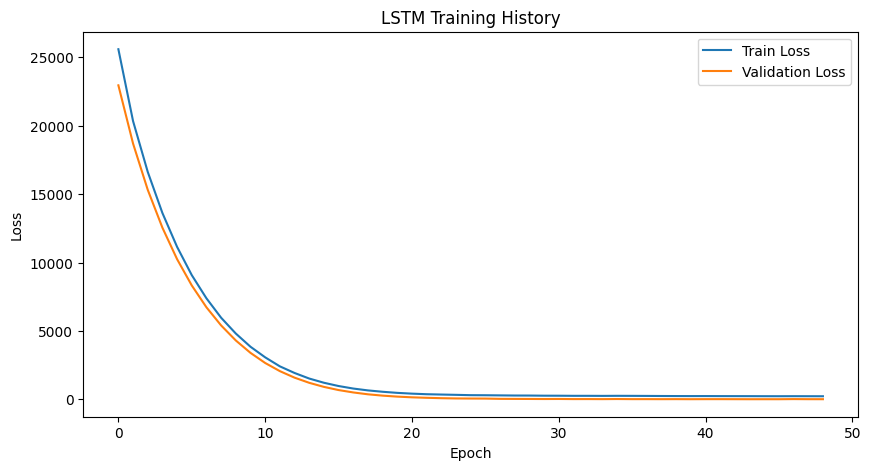

In [52]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [53]:
# Evaluate LSTM
y_train_pred_lstm = lstm_model.predict(X_train_lstm).flatten()
y_test_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

lstm_results = {
    'Model': 'LSTM',
    'Train MAE': mean_absolute_error(y_train_lstm, y_train_pred_lstm),
    'Test MAE': mean_absolute_error(y_test_lstm, y_test_pred_lstm),
    'Train RMSE': np.sqrt(mean_squared_error(y_train_lstm, y_train_pred_lstm)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_lstm, y_test_pred_lstm)),
    'Train R2': r2_score(y_train_lstm, y_train_pred_lstm),
    'Test R2': r2_score(y_test_lstm, y_test_pred_lstm)
}

results_df = results_df.append(lstm_results, ignore_index=True)

457/457 [==============================] - 2s 5ms/step


### <b>Results Comparison and Visualization

In [54]:

print("\n=== Model Performance Comparison ===")
print(results_df)



=== Model Performance Comparison ===
               Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression  26.581577  26.545133   34.808598  34.872496  0.897589   
1      Random Forest   0.159785   0.387817    0.238077   0.586894  0.999995   
2            XGBoost   1.066300   1.160846    1.489639   1.621251  0.999812   
3           LightGBM   1.423848   1.495138    1.874717   1.974169  0.999703   
4  Gradient Boosting   3.573155   3.694948    4.656792   4.808084  0.998167   
5   Ridge Regression  26.581901  26.545643   34.808166  34.872987  0.897591   
6               LSTM   2.354726   2.024977    3.822655   3.360787  0.998765   

    Test R2  
0  0.898580  
1  0.999971  
2  0.999781  
3  0.999675  
4  0.998072  
5  0.898577  
6  0.999058  


In [55]:
# Plot model performance comparison
plt.figure(figsize=(15, 8))


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'LightGBM'),
  Text(4, 0, 'Gradient Boosting'),
  Text(5, 0, 'Ridge Regression'),
  Text(6, 0, 'LSTM')])

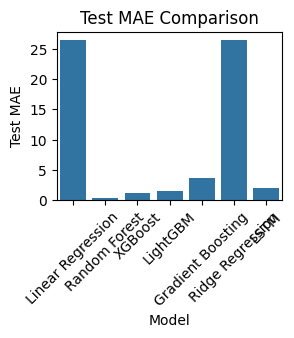

In [56]:
# MAE comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Model', y='Test MAE')
plt.title('Test MAE Comparison')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'LightGBM'),
  Text(4, 0, 'Gradient Boosting'),
  Text(5, 0, 'Ridge Regression'),
  Text(6, 0, 'LSTM')])

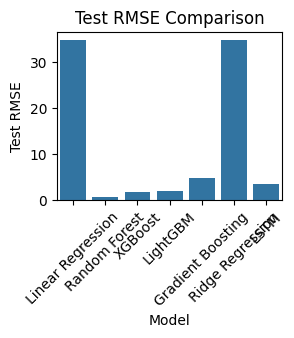

In [57]:
# RMSE comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='Model', y='Test RMSE')
plt.title('Test RMSE Comparison')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'LightGBM'),
  Text(4, 0, 'Gradient Boosting'),
  Text(5, 0, 'Ridge Regression'),
  Text(6, 0, 'LSTM')])

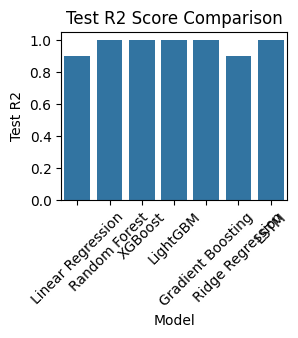

In [58]:
# R2 comparison
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x='Model', y='Test R2')
plt.title('Test R2 Score Comparison')
plt.xticks(rotation=45)


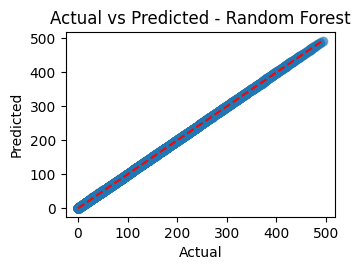

In [59]:
# Actual vs Predicted for best model (based on R2)
best_model_idx = results_df['Test R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

if best_model_name != 'LSTM':
    # Get the best model pipeline
    best_model = {
        'Linear Regression': lr_pipe,
        'Random Forest': rf_pipe,
        'XGBoost': xgb_pipe,
        'LightGBM': lgbm_pipe,
        'Gradient Boosting': gb_pipe,
        'Ridge Regression': ridge_pipe
    }[best_model_name]
    
    y_test_pred = best_model.predict(X_test)
else:
    y_test_pred = y_test_pred_lstm
    y_test = y_test_lstm

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.tight_layout()
plt.show()

In [65]:
# Time series plot of actual vs predicted for a sample product
# Find a product-store combination that exists in both train and test sets
sample_data = df.copy()
sample_data['Date'] = pd.to_datetime(sample_data['Date'])

# Get counts of each product-store combination in train and test
train_indices = df.index[:train_size]
test_indices = df.index[train_size:]

train_counts = df.loc[train_indices].groupby(['Product ID', 'Store ID']).size()
test_counts = df.loc[test_indices].groupby(['Product ID', 'Store ID']).size()

# Find combinations present in both
common_combinations = set(train_counts.index).intersection(set(test_counts.index))

if len(common_combinations) > 0:
    # Select the first available combination
    sample_product, sample_store = list(common_combinations)[0]
    
    print(f"\nPlotting forecast for Product {sample_product} at Store {sample_store}")
    
    # Get the sample data
    sample_data = df[(df['Product ID'] == sample_product) & (df['Store ID'] == sample_store)]
    sample_train = sample_data.iloc[:int(0.8*len(sample_data))]
    sample_test = sample_data.iloc[int(0.8*len(sample_data)):]

    if best_model_name != 'LSTM':
        # Get the test indices for this product-store combination
        test_mask = (df.loc[X_test.index, 'Product ID'] == sample_product) & \
                    (df.loc[X_test.index, 'Store ID'] == sample_store)
        test_indices = X_test.index[test_mask]
        
        if len(test_indices) > 0:
            sample_X_test = X_test.loc[test_indices]
            sample_y_test = y_test.loc[test_indices]
            sample_y_pred = best_model.predict(sample_X_test)
            
            plt.figure(figsize=(12, 6))
            plt.plot(sample_train['Date'], sample_train['Units Sold'], label='Train Actual')
            plt.plot(sample_test['Date'], sample_test['Units Sold'], label='Test Actual')
            plt.plot(sample_test['Date'], sample_y_pred, label='Test Predicted')
            plt.title(f'Sales Forecast for Product {sample_product} at Store {sample_store}')
            plt.xlabel('Date')
            plt.ylabel('Units Sold')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No test samples found for Product {sample_product} at Store {sample_store}")
    else:
        # LSTM case
        sample_test_idx = sample_test.index
        sample_X_test_lstm = X_lstm[sample_test_idx]
        sample_y_test = y_lstm[sample_test_idx]
        sample_y_pred = lstm_model.predict(sample_X_test_lstm).flatten()
        
        plt.figure(figsize=(12, 6))
        plt.plot(sample_train['Date'], sample_train['Units Sold'], label='Train Actual')
        plt.plot(sample_test['Date'], sample_test['Units Sold'], label='Test Actual')
        plt.plot(sample_test['Date'], sample_y_pred, label='Test Predicted')
        plt.title(f'Sales Forecast for Product {sample_product} at Store {sample_store}')
        plt.xlabel('Date')
        plt.ylabel('Units Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No product-store combinations found in both train and test sets")

No product-store combinations found in both train and test sets


In [66]:
# Print feature importance for the best model
if best_model_name != 'LSTM' and best_model_name != 'Linear Regression' and best_model_name != 'Ridge Regression':
    print(f"\nFeature Importance for {best_model_name}:")
    try:
        # Get feature names after one-hot encoding
        feature_names = numerical_cols + list(best_model.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
        
        importances = best_model.named_steps['regressor'].feature_importances_
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
        print(importance_df)
    except:
        print("Could not extract feature importances for this model.")



Feature Importance for Random Forest:
Could not extract feature importances for this model.


In [67]:
# Print final results
print("\n=== Final Model Performance ===")
print(results_df.sort_values('Test R2', ascending=False))


=== Final Model Performance ===
               Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R2  \
1      Random Forest   0.159785   0.387817    0.238077   0.586894  0.999995   
2            XGBoost   1.066300   1.160846    1.489639   1.621251  0.999812   
3           LightGBM   1.423848   1.495138    1.874717   1.974169  0.999703   
6               LSTM   2.354726   2.024977    3.822655   3.360787  0.998765   
4  Gradient Boosting   3.573155   3.694948    4.656792   4.808084  0.998167   
0  Linear Regression  26.581577  26.545133   34.808598  34.872496  0.897589   
5   Ridge Regression  26.581901  26.545643   34.808166  34.872987  0.897591   

    Test R2  
1  0.999971  
2  0.999781  
3  0.999675  
6  0.999058  
4  0.998072  
0  0.898580  
5  0.898577  


The most accurate and precise model is: Random Forest


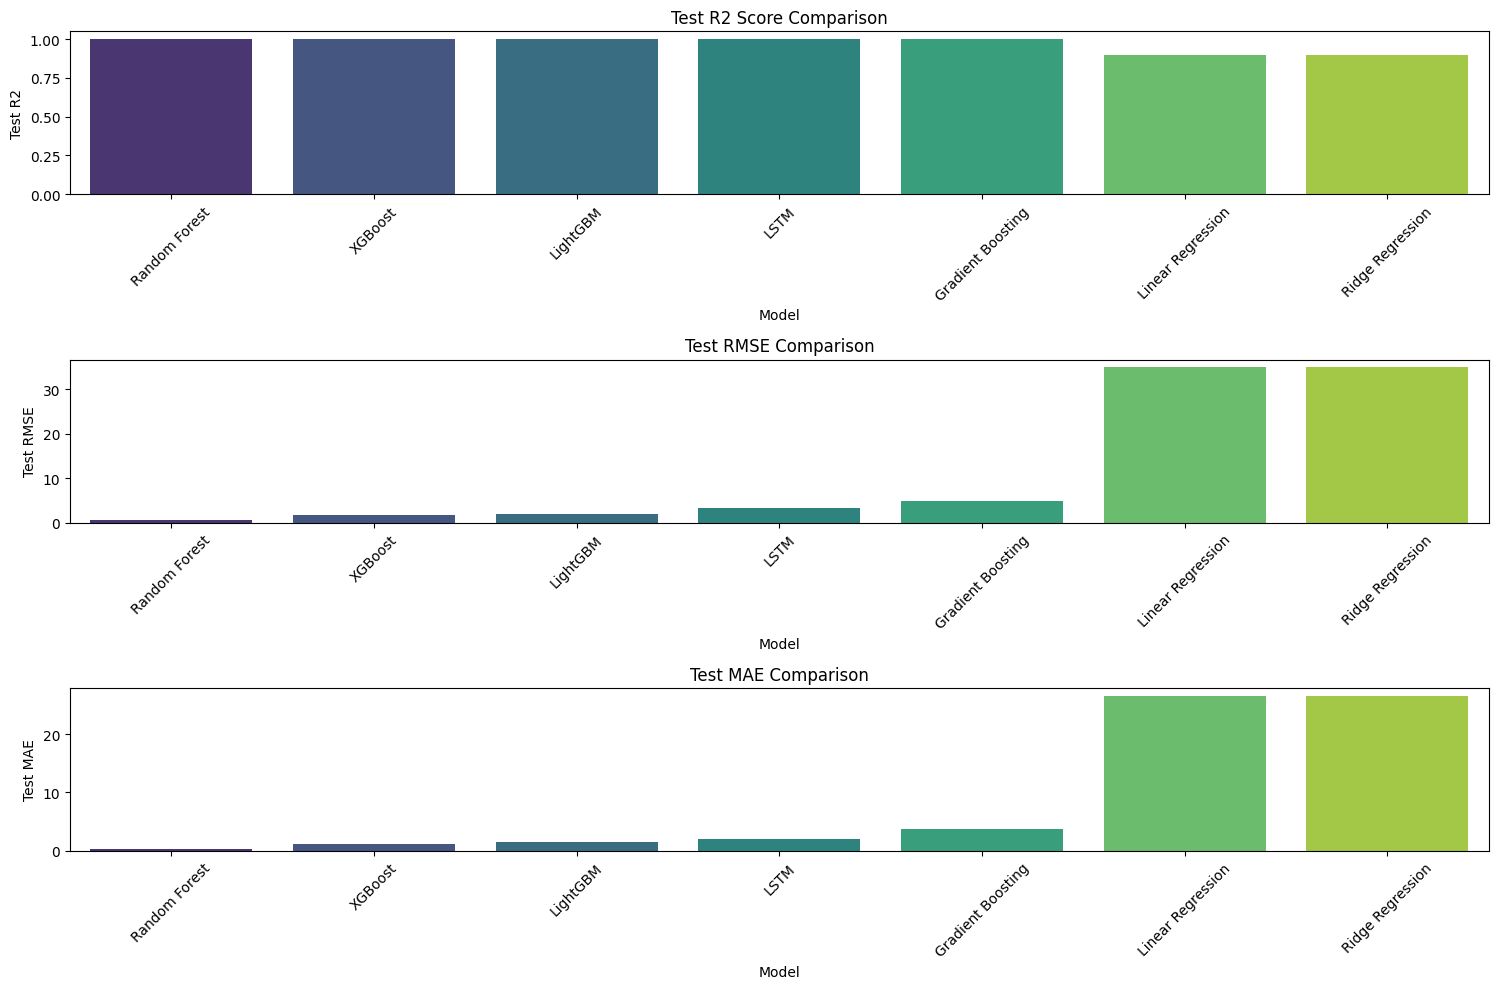


=== Ranked Model Performance ===
               Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R2  \
0      Random Forest   0.159785   0.387817    0.238077   0.586894  0.999995   
1            XGBoost   1.066300   1.160846    1.489639   1.621251  0.999812   
2           LightGBM   1.423848   1.495138    1.874717   1.974169  0.999703   
3               LSTM   2.354726   2.024977    3.822655   3.360787  0.998765   
4  Gradient Boosting   3.573155   3.694948    4.656792   4.808084  0.998167   
5  Linear Regression  26.581577  26.545133   34.808598  34.872496  0.897589   
6   Ridge Regression  26.581901  26.545643   34.808166  34.872987  0.897591   

    Test R2      Rank  
0  0.999971  3.000000  
1  0.999781  3.333333  
2  0.999675  3.666667  
3  0.999058  4.000000  
4  0.998072  4.333333  
5  0.898580  4.666667  
6  0.898577  5.000000  


In [68]:
# Rank models based on Test R2, Test RMSE, and Test MAE
results_df['Rank'] = results_df[['Test R2', 'Test RMSE', 'Test MAE']].rank(
    ascending=[False, True, True], method='min').mean(axis=1)

# Sort results by rank
results_df = results_df.sort_values('Rank').reset_index(drop=True)

# Identify the most accurate and precise model
best_model_name = results_df.loc[0, 'Model']
print(f"The most accurate and precise model is: {best_model_name}")

# Visualization
plt.figure(figsize=(15, 10))

# Test R2 comparison
plt.subplot(3, 1, 1)
sns.barplot(data=results_df, x='Model', y='Test R2', palette='viridis')
plt.title('Test R2 Score Comparison')
plt.xticks(rotation=45)

# Test RMSE comparison
plt.subplot(3, 1, 2)
sns.barplot(data=results_df, x='Model', y='Test RMSE', palette='viridis')
plt.title('Test RMSE Comparison')
plt.xticks(rotation=45)

# Test MAE comparison
plt.subplot(3, 1, 3)
sns.barplot(data=results_df, x='Model', y='Test MAE', palette='viridis')
plt.title('Test MAE Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Display the ranked results
print("\n=== Ranked Model Performance ===")
print(results_df)

In [69]:
from joblib import dump

# Save the top-performing models
dump(rf_pipe, 'random_forest_model.joblib')  # Random Forest
dump(xgb_pipe, 'xgboost_model.joblib')       # XGBoost
dump(lgbm_pipe, 'lightgbm_model.joblib')     # LightGBM
dump(lstm_model, 'lstm_model.joblib')        # LSTM (Neural Network)

print("Models exported successfully!")

INFO:tensorflow:Assets written to: ram://b84d08d6-d098-459e-a11a-19680b4cfeb5/assets


INFO:tensorflow:Assets written to: ram://b84d08d6-d098-459e-a11a-19680b4cfeb5/assets


Models exported successfully!
